Testing a simple version of speckle simulator with simple charge charing included.

In [648]:
from ast import literal_eval as make_tuple
from scipy import ndimage
from skimage.transform import rescale, resize, downscale_local_mean

"""
when photons are absorbed in silicon sensors and turns into electrons, there is a conversion rate.
Every 3.6 eV turns into 1 electron. For example, 360 eV photon will turn into 100 electrons and 7.2 keV
photon will turn into about 2000 electrons. The process of course is not fully deterministic and there
are many other sources of uncertainties and electron/charge loss mechanisms.
"""

def makeSpeckle(size, speckleSize):
    image = np.zeros(size)
    speckleSize = 50 # 30 will lead to a factof of 3 over sampling, thus better maintain the contrast
    xPhasors = int(np.round(size[0]/speckleSize))
    yPhasors = int(np.round(size[1]/speckleSize))
    rndPhasor = np.zeros(size)
    rndPhasor[0:xPhasors,0:yPhasors] = np.exp(np.random.random([xPhasors,yPhasors])*2.j*np.pi)
    speckleField = np.fft.fft2(rndPhasor)
    speckleIntensity = np.abs(speckleField)**2
    return speckleIntensity/np.mean(speckleIntensity.flatten())


def AddShotNoise(speckle, kbar):
    """
    generate speckle pattern as descrete photons by introducing shot noise.
    variable kbar is the average photon density over the field of view.
    """
    speckle = speckle/np.mean(speckle.flatten())*kbar;
    return np.random.poisson(speckle)

def ApplyChargeCloud(photonPattern, cloudSize, photonEnergy):
    """
    this step blurrs the photon map by the charge cloud size, assuming
    every electron in silicon takes 3.6 eV to generate.
    """
    return ndimage.filters.gaussian_filter(photonPattern*photonEnergy/3.6, cloudSize/2.35, mode='wrap', truncate=7)

def rebin(a, shape):
    """
    pattern rebinning down to smaller sizes
    by adding MXN blocks together. IDL type, pretty quick.
    """
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).sum(-1).sum(1)
            

def digitizeCharge(chargePattern, chargePerADU=15, gainMap=None):
    """
    digitize the charge pattern to ADUs, with gain variation
    """
    if gainMap is None:
        gainMap = np.random.randn(chargePattern.shape[0], chargePattern.shape[1])*0.05+1;
    return chargePattern/chargePerADU

    
def AddReadoutNoise(chargePattern, pixelReadoutNoise):
    """
    add readout noise to the detector.
    """
    return chargePattern + np.random.randn(chargePattern.shape[0], chargePattern.shape[1])*pixelReadoutNoise


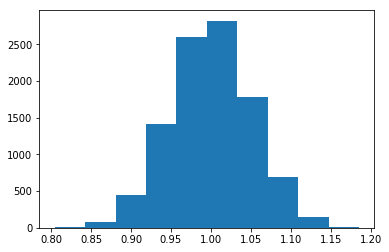

In [642]:
gainMap = np.random.randn(100,100)*0.05+1;
plt.figure()
plt.hist(gainMap.flatten())
plt.show()


/Users/dlzhu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


1.74417996407
142
142.0
142.0
142.0
140.11264029


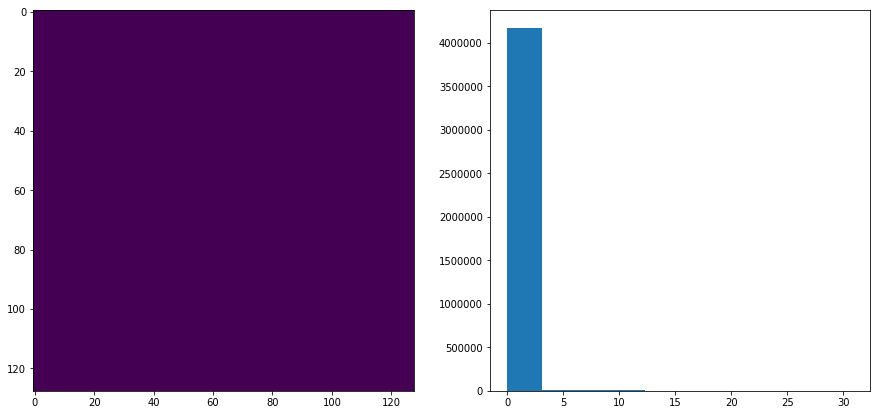

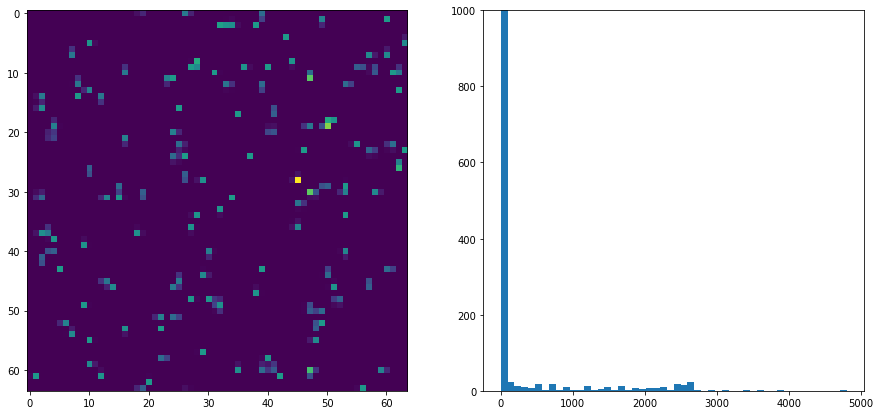

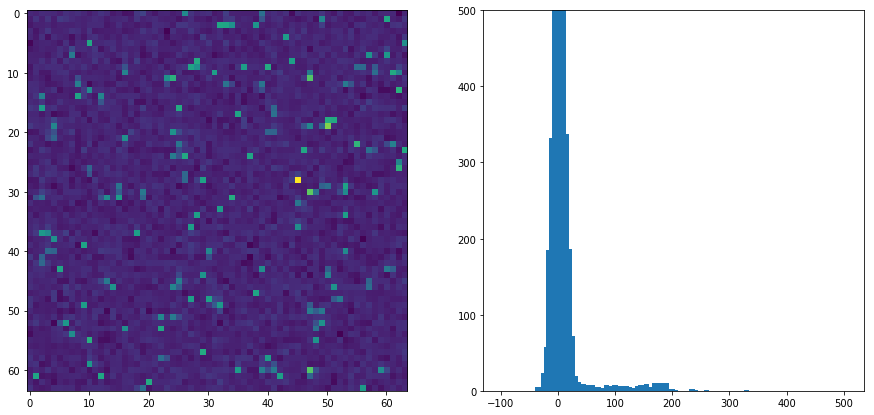

In [651]:
gridSize = [2048,2048]
detectorSize = [64,64]
kbar = 0.04
speckleSize = 50
chargeCloudSize = 0.3
photonEnergy = 9500
readoutNoise = 10
gainVariation = 0.05
gainMap = 1+gainVariation*np.random.randn(detectorSize[0], detectorSize[1])

kbar_grid = kbar/gridSize[0]/gridSize[1]*detectorSize[0]*detectorSize[1]
chargeCloudSize_grid = chargeCloudSize*gridSize[0]/detectorSize[0]

tic = time.time()
speckle = makeSpeckle(gridSize, speckleSize)
speckleN = AddShotNoise(speckle, kbar_grid)
speckleNE = ApplyChargeCloud(speckleN, chargeCloudSize_grid, photonEnergy)
speckleD = rebin(speckleNE, detectorSize)
#speckleD = rebin_slow(speckleNE, 8)
speckleDD = digitizeCharge(speckleD, gainMap = gainMap)
speckleDN = AddReadoutNoise(speckleDD, readoutNoise)
toc = time.time();print(toc-tic)

print(sum(speckleN.flatten()))
print(sum(speckleNE.flatten())/photonEnergy*3.6)
print(sum(speckleD.flatten())/photonEnergy*3.6)
print(sum(speckleDD.flatten())/photonEnergy*3.6*15)
print(sum(speckleDN.flatten())/photonEnergy*3.6*15)

if False:
    plt.figure(figsize=[15,7]);plt.clf();
    plt.subplot(1,2,1);
    plt.imshow(speckle)
    plt.subplot(1,2,2);
    plt.hist(speckle.flatten())

    # charge distribution
plt.figure(figsize=[15,7]);plt.clf();
plt.subplot(1,2,1);
plt.imshow(speckleNE[0:128,0:128])
plt.subplot(1,2,2);
plt.hist(speckleNE.flatten())

# pixel charge distribution
plt.figure(figsize=[15,7]);plt.clf();
plt.subplot(1,2,1);
plt.imshow(speckleD)
plt.subplot(1,2,2);
plt.hist(speckleD.flatten(), 50)
plt.ylim(0,1000)

# final pattern
plt.figure(figsize=[15,7]);plt.clf();
plt.subplot(1,2,1);
plt.imshow(speckleDN)
plt.subplot(1,2,2);
binWidth = 5;
bins = np.arange(-100, 500.1, binWidth)
histFinal = np.histogram(speckleDN.flatten(), bins)
plt.bar(bins[1:], histFinal[0], width=10)
plt.ylim(0,500)
plt.show()
    



In [599]:
def makeWeakSpeckle(kbar, speckleSize = 50, gridSize=[1024,1024], detectorSize=[128,128], chargeCloudSize=2,
                    photonEnergy=9500, readoutNoise=10):
    """
    use the functions in the earlier section to produce a single detector image of
    a weak speckle pattern with average signal rate of kbar.
    """
    kbar_grid = kbar/gridSize[0]/gridSize[1]*detectorSize[0]*detectorSize[1]
    chargeCloudSize_grid = chargeCloudSize*gridSize[0]/detectorSize[0]
    print chargeCloudSize_grid
    speckle = makeSpeckle(gridSize, speckleSize)
    speckleN = AddShotNoise(speckle, kbar_grid)
    speckleNE = ApplyChargeCloud(speckleN, chargeCloudSize_grid, photonEnergy)
    speckleD = rebin(speckleNE, detectorSize)
    speckleDD = digitizeCharge(speckleD)
    return AddReadoutNoise(speckleDD, readoutNoise)

def makeFlatPoisson(kbar, gridSize=[1024,1024], detectorSize =[128,128], chargeCloudSize=2.0, photonEnergy=9500.0,
                    readoutNoise=10.0):
    
    chargeCloudSize_grid = chargeCloudSize*gridSize[0]/detectorSize[0]
    kbar_grid = kbar/gridSize[0]/gridSize[1]*detectorSize[0]*detectorSize[1]
    pattern = np.ones(gridSize)
    patternN = AddShotNoise(pattern, kbar_grid)
    patternNE = ApplyChargeCloud(patternN, chargeCloudSize_grid, photonEnergy)
    patternD = rebin(patternNE, detectorSize)
    patternDD = digitizeCharge(patternD)
    return AddReadoutNoise(patternDD, readoutNoise)

In [579]:
a = np.random.poisson(np.ones([4,4])*0.2)
b = ApplyChargeCloud(a, 1, 1)
print(sum(a.flatten()))
print(sum(b.flatten())*3.6)

1
1.0


In [657]:
np.zeros(2,3)

TypeError: data type not understood

In [676]:
binWidth = 10;
bins = np.arange(-100, 1000.1, binWidth)
histFinal = np.zeros([np.shape(bins)[0]-1, 3])
nPhoton = 0
kbar = 0.1
ccs=0.5
rn=3

N = 100
for k in range(3):
    for i in range(N):
        if np.mod(i,10) == 0:
            print i
        #speckle = makeWeakSpeckle(kbar, chargeCloudSize=ccs, readoutNoise=rn)
        speckle = makeFlatPoisson(kbar, chargeCloudSize=ccs, readoutNoise=rn, detectorSize=[32,32])
        nPhoton += (sum(speckle.flatten())/9500*3.6*15);
        histHere = np.histogram(speckle.flatten(), bins)
        histFinal[:,k] +=histHere[0]
print('DONE\n');
print('total number of photons: %d\n' % nPhoton)
print('simulated kbar: %.6f\n' % (nPhoton/128/128/N))

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
DONE

total number of photons: 30750

simulated kbar: 0.018769



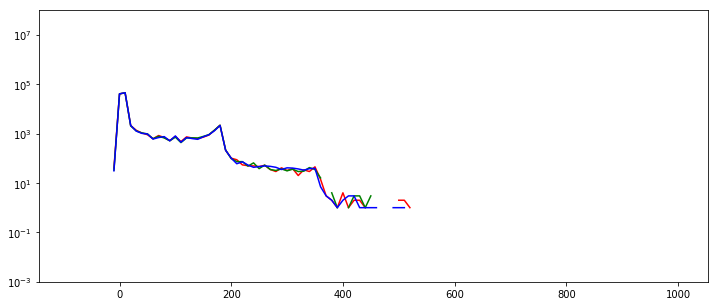

In [675]:
# take a look at the sum histogram, trying to make it similar to a real detector
# ... still some artifact from 32x32 spatial sampling of a pixel

plt.figure(figsize=[12,5]);plt.clf();
plt.semilogy(bins[1:], histFinal[:,0], 'r')
plt.semilogy(bins[1:], histFinal[:,1], 'g')
plt.semilogy(bins[1:], histFinal[:,2], 'b')
plt.ylim(1e-3,1e8)
plt.show()


In [283]:
import multiprocessing as mp

def PhotonHistBatch(N):
    """generate a histogram from 100 images"""
    binWidth = 10;
    bins = np.arange(-100, 1000.1, binWidth)
    histFinal = np.zeros(np.shape(bins)[0]-1, 20)

    for i in prange(N):
        if np.mod(i,10) == 0:
            print i
        speckle = makeWeakSpeckle(0.03, chargeCloudSize=5, readoutNoise=10)
        histHere = np.histogram(speckle.flatten(), bins)
        histFinal +=histHere[0]      
    return histFinal

def main():
    pool = mp.Pool(4)
    result = pool.map(PhotonHistBatch, [20,20,20,20])
    
if __name__ == "__main__":
    main()

TypeError: data type not understood

In [281]:
import multiprocessing as mp

def my_func(x):
  print(x**x)
  return x**x

def main():
  pool = mp.Pool(mp.cpu_count())
  result = pool.map(my_func, [4,2,3])
  print result

if __name__ == "__main__":
  main()

27
256
4
[256, 4, 27]


In [506]:
n = np.ones([8,8])
nr = rebin(n,[2,2])
print n
print nr

[[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]]
[[ 16.  16.]
 [ 16.  16.]]


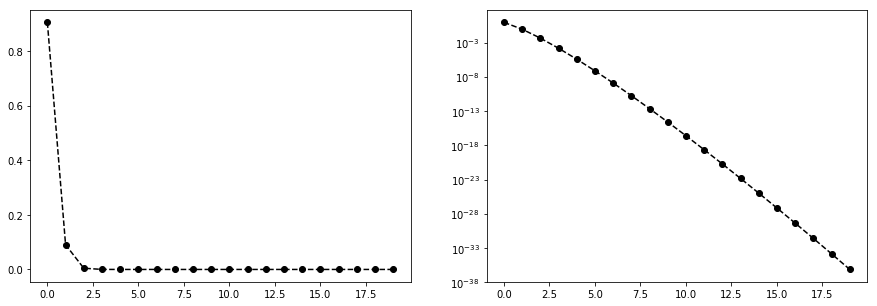

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2]
 [ 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4
   0.4]
 [ 0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6
   0.6]
 [ 0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8
   0.8]
 [ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1. ]
 [ 1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2
   1.2]
 [ 1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4
   1.4]
 [ 1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6
   1.6]
 [ 1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8
   1.8]
 [ 2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2. ]
 [ 2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2
   2.2]
 [ 2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4

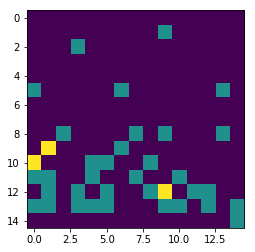

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 2 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [2 0 0 0 1 1 0 0 1 0 0 0 0 0 0]
 [1 1 0 0 1 0 0 1 0 0 1 0 0 0 0]
 [0 1 0 1 0 1 0 0 1 2 0 1 1 0 0]
 [1 1 0 1 1 1 0 0 0 1 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [67]:
"""test generating poission probabilities ... seems good for small k expectation values,
and some numerical divergence when go to bigger values than 20.
if we use np.random.choice, we need to provide the poission probability distribution, or we can use the build in
poission random function."""

import numpy as np
from scipy.special import factorial
from matplotlib import pyplot as plot
k = np.arange(20)
k_expectation = 0.1
poisson_dist = np.exp(-k_expectation)*(k_expectation**k)/factorial(k);

plt.figure(figsize = [15,5]);plt.clf;
plt.subplot(1,2,1)
plt.plot(poisson_dist, '--ok')
plt.subplot(1,2,2)
plt.semilogy(poisson_dist, '--ok')
plt.show()

# now use the built in function
a = np.mgrid[0:3:0.2,0:3:0.2]
print a[0]
ar = np.random.poisson(a[0]*0.1)

plt.figure();
plt.imshow(ar)
plt.show()
print ar